In [ ]:
!wget http://nlp.stanford.edu/data/glove.42B.300d.zip

--2025-01-04 00:41:23--  http://nlp.stanford.edu/data/glove.42B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.42B.300d.zip [following]
--2025-01-04 00:41:23--  https://nlp.stanford.edu/data/glove.42B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.42B.300d.zip [following]
--2025-01-04 00:41:24--  https://downloads.cs.stanford.edu/nlp/data/glove.42B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1877800501 (1.7G) [application/zip]


In [ ]:
# mount google drive for retrieving datasets
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/tickets.zip -d datasets/

Archive:  /content/drive/MyDrive/tickets.zip
  inflating: datasets/all_tickets_processed_improved_v3.csv  


In [ ]:
!unzip glove.42B.300d.zip -d glove.42B/

Archive:  glove.42B.300d.zip
  inflating: glove.42B/glove.42B.300d.txt  


In [ ]:
import os
import sys
import pandas as pd
import warnings

pd.set_option('display.max_colwidth', 500)

from matplotlib import pyplot as plt


In [ ]:
df = pd.read_csv("./datasets/all_tickets_processed_improved_v3.csv")

### Data Preparation

In [ ]:
# view few rows
df.head()

,Document,Topic_group
0,connection with icon icon dear please setup icon per icon engineers please let other details needed thanks lead,Hardware
1,work experience user work experience user hi work experience student coming next his name much appreciate him duration thank,Access
2,requesting for meeting requesting meeting hi please help follow equipments cable pc cord plug,Hardware
3,reset passwords for external accounts re expire days hi ask help update passwords colleagues thank pm expire days importance high hi received about expiration please kindly help prolongation best regards pm expire days importance high dear expire days order change please follow steps prerequisites disable device credentials close active connected by cable machine note also follow steps detailed press ctrl alt delete same pops change item enter format enter enter newly chosen then re enter ag...,Access
4,mail verification warning hi has got attached please addresses best regards monitoring analyst verification warning,Miscellaneous


In [ ]:
# check missing values
df.isna().sum()

,0
Document,0
Topic_group,0


No missing values found

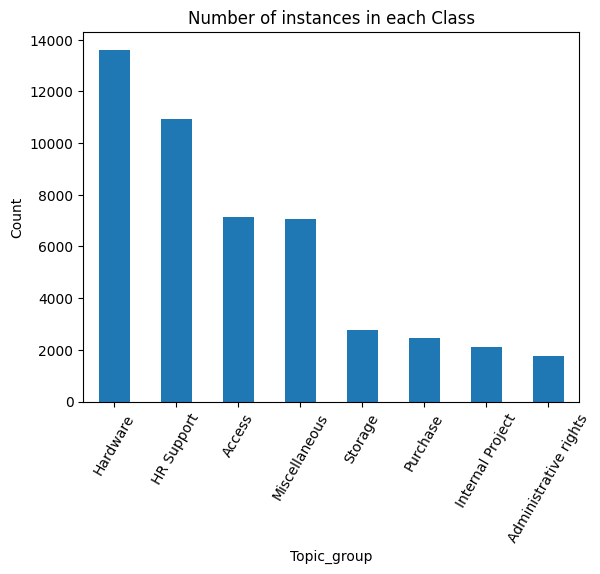

In [ ]:
# Number of classes in target
df["Topic_group"].value_counts().plot(kind="bar")
plt.title("Number of instances in each Class")
plt.ylabel("Count")
plt.xticks(rotation=60)
plt.show()

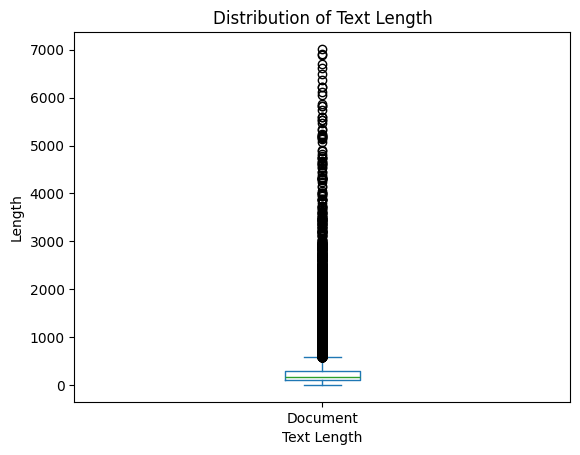

In [ ]:
#distribution of ticket desription lengths
df["Document"].apply(lambda x : len(x)).plot(kind="box")
plt.title("Distribution of Text Length")
plt.ylabel("Length")
plt.xlabel("Text Length")
plt.show()

In [ ]:
# check 5 point summary of service request description length
df["Document"].apply(lambda x : len(x)).describe()

,Document
count,47837.000000
mean,291.881263
std,388.171200
min,7.000000
25%,110.000000
50%,175.000000
75%,304.000000
max,7015.000000


In [ ]:
# split train and test portions
test_df = df.sample(frac=0.2, random_state=42, replace=True)
train_df = df.drop(test_df.index)

Data can be directly loaded to Tensors which suitable for training using `text_dataset_from_directory` utility, which expects a directory structure as follows.
main_directory/

    ...class_a/
        ......a_text_1.txt
        ......a_text_2.txt
        
    ...class_b/
        ......b_text_1.txt
        ......b_text_2.txt

Hence the source dataset must be processed to be loaded in disk accodingly.

In [ ]:
# store each service request description and its topic in above directory structure
classes = ['Hardware',
 'Access',
 'Miscellaneous',
 'HR Support',
 'Purchase',
 'Administrative rights',
 'Storage',
 'Internal Project']

for class_name in classes:
    os.makedirs(os.path.join("./datasets/deep_learning/train/",class_name))
    for row in train_df[train_df["Topic_group"]==class_name].iterrows():
        with open(os.path.join("./datasets/deep_learning/train",f"{class_name}/{row[0]}.txt"), "w") as fh:
                fh.write(row[1]["Document"])
for class_name in classes:
    os.makedirs(os.path.join("./datasets/deep_learning/test/",class_name))
    for row in test_df[test_df["Topic_group"]==class_name].iterrows():
        with open(os.path.join("./datasets/deep_learning/test",f"{class_name}/{row[0]}.txt"), "w") as fh:
                fh.write(row[1]["Document"])

#### Load data into `tf.data.Dataset`

In [ ]:

# warnings.filterwarnings("ignore")
# from zipfile import ZipFile
from tensorflow.keras import layers
from tensorflow.keras import losses
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, InputLayer
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, LSTM, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import Constant
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow import keras

import matplotlib.pyplot as plt
import re
import string
import os
import numpy as np

In [ ]:
# The dataset lacks a validation set. Let's create a validation set using an 80:20 split of the training data
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    './datasets/deep_learning/train/',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 39163 files belonging to 8 classes.
Using 31331 files for training.


In [ ]:
# Check few data
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'change for project wednesday july change hi side please change next schema story task progress done schema story task progress resolution done thank best regards senior engineer'
Label 5
Review b'wants to access practices thursday february pm wants practices dear colleagues job descriptions available layouts source accept decline'
Label 7
Review b'rule update rule update hi please update rule created snow tickets please exists wireless anymore rule create tickets digital realty remain thanks infrastructure upcoming leave'
Label 5


In [ ]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    './datasets/deep_learning/train/',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 39163 files belonging to 8 classes.
Using 7832 files for validation.


In [ ]:
# test set
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    './datasets/deep_learning/test/',
    batch_size=batch_size)

Found 8674 files belonging to 8 classes.


In [ ]:
# custom funtion to clean and remove punctuation
def custom_standardization(text):
    lowercase_string = tf.strings.lower(text)
    regex_clean = tf.strings.regex_replace(
            lowercase_string, f"[0-9\\r\\t\\n{re.escape(string.punctuation)}]", "")
    return regex_clean

### Preprocessing - Tokenization and Text Vectorization using Integer seqences

In [ ]:
max_features = 10000 # max number of tokens
sequence_length = 512 #Q3 length is 304

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [ ]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [ ]:
# Apply text vectorization to all the sets
train_ds = raw_train_ds.map(lambda x,y : (vectorize_layer(x),y), num_parallel_calls=4)
val_ds = raw_val_ds.map(lambda x,y : (vectorize_layer(x),y), num_parallel_calls=4)
test_ds = raw_test_ds.map(lambda x,y : (vectorize_layer(x),y), num_parallel_calls=4)

In [ ]:
# check one vextorized txt nd label
for text, label in train_ds.take(1):
    print(text[0], label[0])
    break

tf.Tensor(
[ 128   30    7 6093  707  220   30    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

In [ ]:
# Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### Sequential Neural Network Model with Own Embedding

In [ ]:
def get_simple_model(max_tokens, hidden_dim=16):
    model = tf.keras.Sequential([
    layers.Embedding(max_tokens, 16),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(8, activation='sigmoid')])
    return model


In [ ]:
simple_model = get_simple_model(max_features)
simple_model.compile(loss=losses.SparseCategoricalCrossentropy(),
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
simple_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 50
history_simple_model = simple_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.2714 - loss: 1.8701 - val_accuracy: 0.3436 - val_loss: 1.7973
Epoch 2/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3117 - loss: 1.8077 - val_accuracy: 0.4176 - val_loss: 1.7289
Epoch 3/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3572 - loss: 1.7258 - val_accuracy: 0.4491 - val_loss: 1.6165
Epoch 4/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4305 - loss: 1.6018 - val_accuracy: 0.4914 - val_loss: 1.4757
Epoch 5/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5057 - loss: 1.4612 - val_accuracy: 0.5446 - val_loss: 1.3428
Epoch 6/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5759 - loss: 1.3196 - val_accuracy: 0.5546 - val_loss: 1.2147
Epoch 7/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6304 - loss: 1.1831 - val_accuracy: 0.6549 - val_loss: 1.0875
Epoch 8/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6859 - loss: 1.0622 - val_accuracy: 0.

In [ ]:
loss_baseline, accuracy_baseline = simple_model.evaluate(test_ds)

print("Loss: ", loss_baseline)
print("Accuracy: ", accuracy_baseline)

272/272 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8349 - loss: 0.4958
Loss:  0.49667587876319885
Accuracy:  0.8397510051727295


#### GloVe Embedding - Sequential Neural Network

In [ ]:
BASE_DIR = os.getcwd()
GLOVE_DIR = os.path.join(BASE_DIR, 'glove.42B')

In [ ]:
# Parsing the GloVe word-embeddings file
path_to_glove_file = os.path.join(GLOVE_DIR, 'glove.42B.300d.txt')

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

Found 1917494 word vectors.


In [ ]:
# Preparing the GloVe word-embeddings matrix
embedding_dim = 300

vocabulary = vectorize_layer.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))

embedding_matrix = np.zeros((max_features, embedding_dim))
for word, i in word_index.items():
    if i < max_features:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = layers.Embedding(
    max_features,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

In [ ]:
def get_glove_model():
    model = tf.keras.Sequential([
    embedding_layer,
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(8, activation='sigmoid')])
    return model


In [ ]:
glove_model = get_glove_model()
glove_model.compile(loss=losses.SparseCategoricalCrossentropy(),
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
glove_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 50
history_glove = glove_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.4142 - loss: 1.6207 - val_accuracy: 0.6527 - val_loss: 1.1240
Epoch 2/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6532 - loss: 1.0778 - val_accuracy: 0.6947 - val_loss: 0.9558
Epoch 3/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6882 - loss: 0.9485 - val_accuracy: 0.7134 - val_loss: 0.8816
Epoch 4/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7008 - loss: 0.8875 - val_accuracy: 0.7222 - val_loss: 0.8394
Epoch 5/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7119 - loss: 0.8507 - val_accuracy: 0.7306 - val_loss: 0.8113
Epoch 6/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7138 - loss: 0.8291 - val_accuracy: 0.7329 - val_loss: 0.7917
Epoch 7/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7185 - loss: 0.8159 - val_accuracy: 0.7372 - val_loss: 0.7769
Epoch 8/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7244 - loss: 0.8032 - val_accuracy: 0

In [ ]:
loss_glove, accuracy_glove = glove_model.evaluate(test_ds)

print("Loss: ", loss_glove)
print("Accuracy: ", accuracy_glove)

272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7743 - loss: 0.6667
Loss:  0.6645898818969727
Accuracy:  0.7750749588012695


#### Own Embedding 1D CNN

In [ ]:
def get_cnn_model_own_embedding(max_tokens, embedding_dim, hidden_dim=16):
    inputs = keras.Input(shape=(None,), dtype="int64")
    embedded = layers.Embedding(input_dim=max_tokens, output_dim=embedding_dim)(inputs)
    x = layers.Conv1D(hidden_dim, 5, activation='relu')(embedded)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dense(hidden_dim, activation='relu')(x)
    outputs = layers.Dense(8, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    return model

In [ ]:
cnn_own_model = get_cnn_model_own_embedding(max_features,embedding_dim,16)
cnn_own_model.compile(loss=losses.SparseCategoricalCrossentropy(),
              optimizer='adam',
              metrics=['accuracy'])
cnn_own_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_2 (Embedding)              │ (None, None, 300)           │       3,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, None, 16)            │          24,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 16)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │             136 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,024,424 (11.54 MB)

 Trainable params: 3,024,424 (11.54 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 20
cnn_own_model_history = cnn_own_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/20
980/980 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.5798 - loss: 1.1813 - val_accuracy: 0.8188 - val_loss: 0.5302
Epoch 2/20
980/980 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.8591 - loss: 0.4141 - val_accuracy: 0.8233 - val_loss: 0.5254
Epoch 3/20
980/980 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9197 - loss: 0.2466 - val_accuracy: 0.8278 - val_loss: 0.5754
Epoch 4/20
980/980 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9571 - loss: 0.1437 - val_accuracy: 0.8228 - val_loss: 0.6514
Epoch 5/20
980/980 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9788 - loss: 0.0855 - val_accuracy: 0.8189 - val_loss: 0.7511
Epoch 6/20
980/980 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9868 - loss: 0.0579 - val_accuracy: 0.8147 - val_loss: 0.8484
Epoch 7/20
980/980 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9904 - loss: 0.0449 - val_accuracy: 0.8076 - val_loss: 0.9431
Epoch 8/20
980/980 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9911 - loss: 0.0340 - val_accuracy

In [ ]:
loss_cnn, accuracy_cnn = cnn_own_model.evaluate(test_ds)

print("Loss: ", loss_cnn)
print("Accuracy: ", accuracy_cnn)

272/272 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8130 - loss: 1.6587
Loss:  1.5973360538482666
Accuracy:  0.814157247543335


#### Own Embedding LSTM

In [ ]:
def get_lstm_model_own_embedding(max_tokens, hidden_dim=16):
    inputs = keras.Input(shape=(None,), dtype="int64")
    embedded = layers.Embedding(input_dim=max_tokens, output_dim=embedding_dim)(inputs)
    x = layers.Bidirectional(layers.LSTM(32))(embedded)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(8, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    return model

In [ ]:
lstm_model = get_lstm_model_own_embedding(max_features, embedding_dim)
lstm_model.compile(loss=losses.SparseCategoricalCrossentropy(),
              optimizer='adam',
              metrics=['accuracy'])
lstm_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_3 (Embedding)              │ (None, None, 300)           │       3,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 64)                  │          85,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,085,768 (11.77 MB)

 Trainable params: 3,085,768 (11.77 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 20
lstm_model_history = lstm_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/20
980/980 ━━━━━━━━━━━━━━━━━━━━ 47s 43ms/step - accuracy: 0.6377 - loss: 1.0779 - val_accuracy: 0.8324 - val_loss: 0.5402
Epoch 2/20
980/980 ━━━━━━━━━━━━━━━━━━━━ 46s 47ms/step - accuracy: 0.8534 - loss: 0.4935 - val_accuracy: 0.8276 - val_loss: 0.5345
Epoch 3/20
980/980 ━━━━━━━━━━━━━━━━━━━━ 79s 44ms/step - accuracy: 0.8863 - loss: 0.3821 - val_accuracy: 0.8338 - val_loss: 0.5366
Epoch 4/20
980/980 ━━━━━━━━━━━━━━━━━━━━ 81s 43ms/step - accuracy: 0.9042 - loss: 0.3244 - val_accuracy: 0.8362 - val_loss: 0.5517
Epoch 5/20
980/980 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.9196 - loss: 0.2750 - val_accuracy: 0.8329 - val_loss: 0.5822
Epoch 6/20
980/980 ━━━━━━━━━━━━━━━━━━━━ 46s 47ms/step - accuracy: 0.9314 - loss: 0.2401 - val_accuracy: 0.8331 - val_loss: 0.6214
Epoch 7/20
980/980 ━━━━━━━━━━━━━━━━━━━━ 81s 46ms/step - accuracy: 0.9386 - loss: 0.2087 - val_accuracy: 0.8325 - val_loss: 0.6426
Epoch 8/20
980/980 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.9494 - loss: 0.1836 - 

In [ ]:
loss_lstm, accuracy_lstm = lstm_model.evaluate(test_ds)

print("Loss: ", loss_lstm)
print("Accuracy: ", accuracy_lstm)

272/272 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.8222 - loss: 0.9780
Loss:  0.9795267581939697
Accuracy:  0.825455367565155


#### LSTM - Glove Embedding

In [ ]:
def get_lstm_glove_model():
    inputs = keras.Input(shape=(None,), dtype="int64")
    embedded = embedding_layer(inputs)
    x = layers.Bidirectional(layers.LSTM(32))(embedded)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(8, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    return model


In [ ]:
lstm_glove_model = get_lstm_glove_model()
lstm_glove_model.compile(loss=losses.SparseCategoricalCrossentropy(),
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
lstm_glove_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 300)      │      3,000,000 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_1 (NotEqual)    │ (None, None)           │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 64)             │         85,248 │ embedding_1[1][0],     │
│ (Bidirectional)           │                        │                │ not_equal_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 64)             │              0 │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 8)              │            520 │ dropout_5[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,085,768 (11.77 MB)

 Trainable params: 85,768 (335.03 KB)

 Non-trainable params: 3,000,000 (11.44 MB)

In [ ]:
epochs = 20
history_lstm_glove = lstm_glove_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/20


In [ ]:
loss_lstm_glove, accuracy_lstm_glove = lstm_glove_model.evaluate(test_ds)

print("Loss: ", loss_lstm_glove)
print("Accuracy: ", accuracy_lstm_glove)

272/272 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8631 - loss: 0.5086
Loss:  0.506784200668335
Accuracy:  0.8626931309700012


In [ ]:
# create a dataframe forall the model scores
scores_df = pd.DataFrame(data=[
    [loss_baseline, accuracy_baseline],
    [loss_glove, accuracy_glove],
    [loss_cnn, accuracy_cnn],
    [loss_lstm, accuracy_lstm],
    [loss_lstm_glove, accuracy_lstm_glove],
],
columns=["Loss", "Accuracy"],
index=["Sequential-Own Embedding", "Sequential-GloVe","CNN-Own Embedding", "LSTM-Own Embedding", "LSTM-GloVe"])
scores_df.round(3)


,Loss,Accuracy
Sequential-Own Embedding,0.497,0.840
Sequential-GloVe,0.665,0.775
CNN-Own Embedding,1.597,0.814
LSTM-Own Embedding,0.980,0.825
LSTM-GloVe,0.507,0.863


In [ ]:
# create a html table of the above scores
scores_df.round(3).to_html("./scores.html")

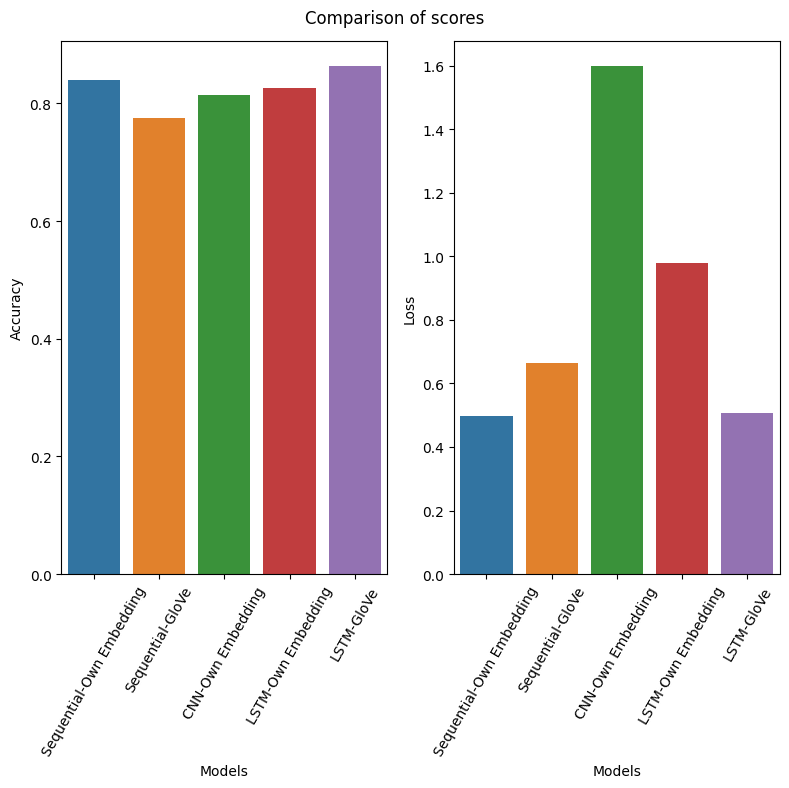

In [ ]:
# plot the model scores
import seaborn as sns
fig,ax = plt.subplots(nrows=1,ncols=2,figsize = (8,8))
fig.suptitle("Comparison of scores")
sns.barplot(ax=ax[0],data=scores_df, x=scores_df.index, y="Accuracy", hue=scores_df.index)
ax[0].set_xlabel("Models")
ax[0].set_xticks(scores_df.index)
ax[0].set_xticklabels(["Sequential-Own Embedding", "Sequential-GloVe","CNN-Own Embedding", "LSTM-Own Embedding", "LSTM-GloVe"], rotation=60)

sns.barplot(ax=ax[1],data=scores_df, x=scores_df.index, y="Loss",hue=scores_df.index)
ax[1].set_xlabel("Models")
ax[1].set_xticks(scores_df.index)
ax[1].set_xticklabels(["Sequential-Own Embedding", "Sequential-GloVe","CNN-Own Embedding", "LSTM-Own Embedding", "LSTM-GloVe"], rotation=60)

plt.tight_layout()
plt.show()

#### Curves

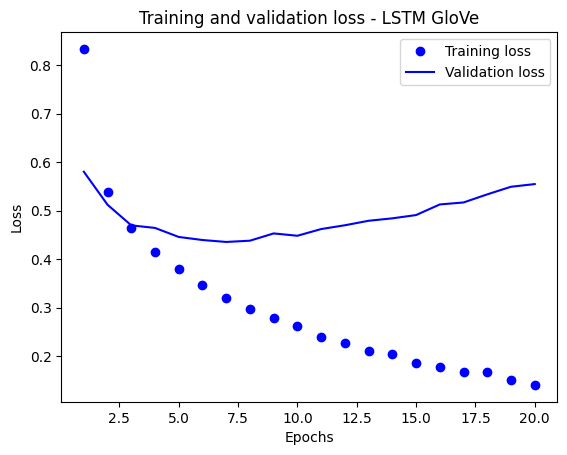

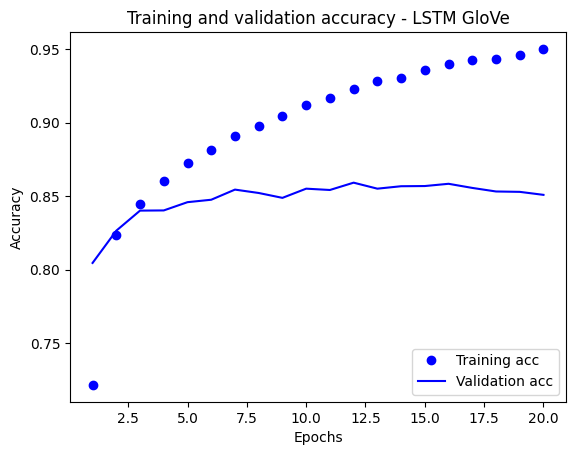

In [61]:
history_dict = history_lstm_glove.history
history_dict.keys()
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss - LSTM GloVe')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy - LSTM GloVe')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()


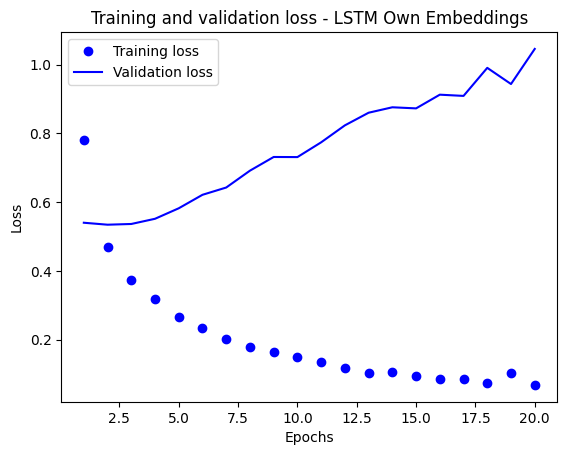

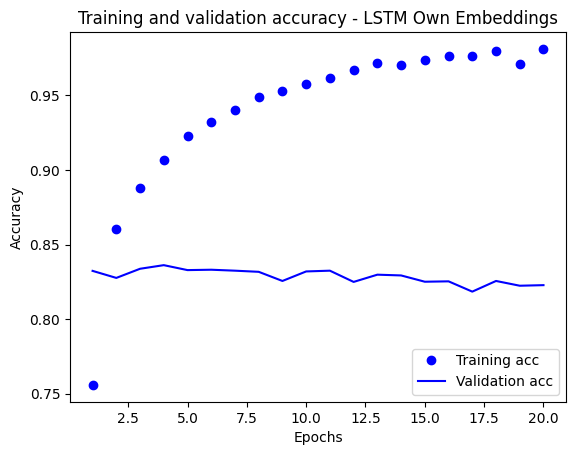

In [62]:
history_dict = lstm_model_history.history
history_dict.keys()
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss - LSTM Own Embeddings')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy - LSTM Own Embeddings')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

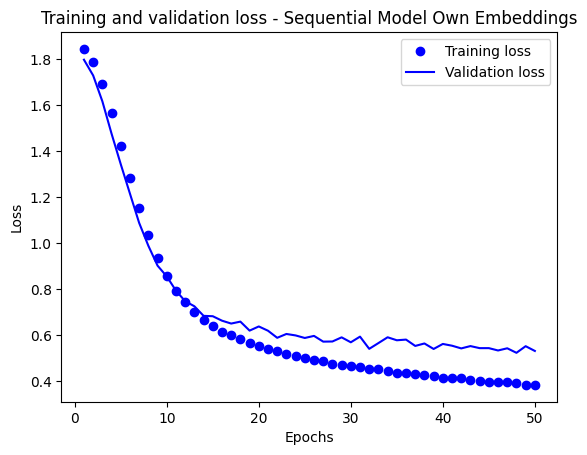

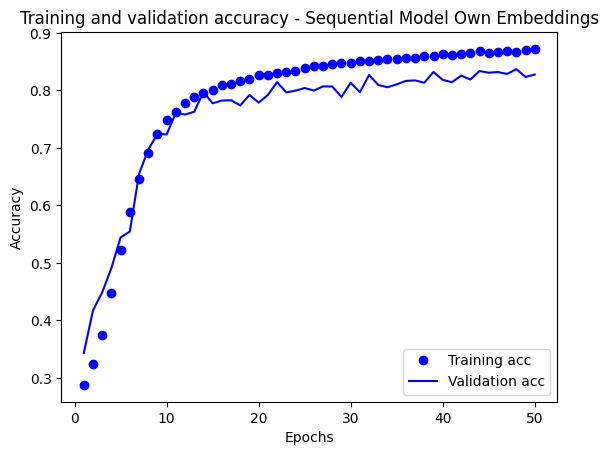

In [64]:
history_dict = history_simple_model.history
history_dict.keys()
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss - Sequential Model Own Embeddings')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy - Sequential Model Own Embeddings')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

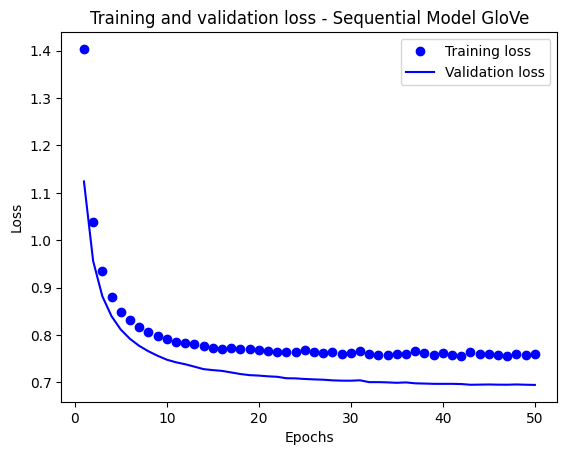

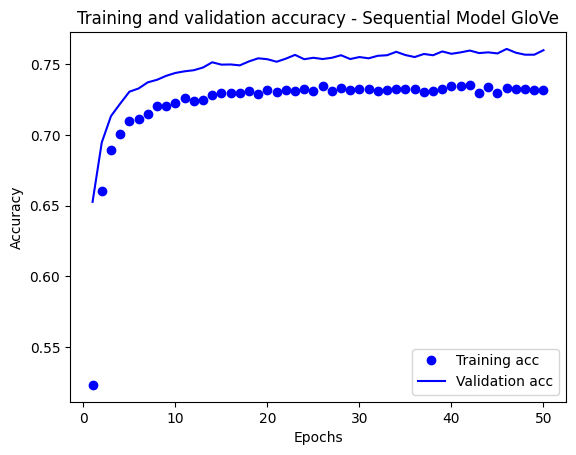

In [65]:
history_dict = history_glove.history
history_dict.keys()
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss - Sequential Model GloVe')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy - Sequential Model GloVe')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()